## <center> Homework 7 </center>
<center> Tara Wilson </center>
<center> DATA 558 </center>
<center> May 25, 2019 </center>

In [1]:
# imports
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from numpy.linalg import inv
import scipy.linalg
import random
import copy 
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Exercise 1

**Study Lab #7 and do exercises therin**  

See seperate submission attachment.

### Exercise 2

**In this problem you will implement in Python a first version of your own kernerl support vector machine with the smoothed hinge loss.**  

The kernel support vector maching with the smoothed hinge loss writes as
$min F(\alpha) := \frac {1}{n} \sum_{i=1}^{n} l_{hh}(y_i,(K\alpha)_i) + \lambda \alpha^T K \alpha$    

where $K(\alpha)_i$ is the *i*th entry in the vector $K\alpha$,  

$\begin{equation}
l_{hh}(y, t) := \begin{cases}
    0 \text{    if    } yt > 1 + h \\  
    \frac{(1+h-yt)^2}{4h} \text{    if    } |1 - yt| \leq h \\  
    1 - yt \text{    if    } yt < 1 - h  
    \end{cases}
\end{equation}$  

and h = 0.5

**Compute the gradient $\nabla(\alpha)$ of F**

To solve for the gradient of F we will need to calculate the derivative:  
$\nabla F(\alpha) = \frac{1}{n} \sum_{i=1}^{n} \frac{\partial}{\partial \alpha} l_{hh}(y_i, (K\alpha)_i) + \frac{\partial}{\partial \alpha} \lambda \alpha^T K \alpha$  

I will break this in to two terms:  
$g'(\alpha) = \frac{\partial}{\partial \alpha} l_{hh}(y_i, (K\alpha)_i)$  
$h'(\alpha) = \frac{\partial}{\partial \alpha} \lambda \alpha^T K \alpha$ 

First, solving for $g'(\alpha)$, we have several cases:  
$\begin{equation}
l_{hh}(y_i, (K\alpha)_i) := \begin{cases}
    0 \text{    if    } y_i(K\alpha)_i > 1 + h \\  
    \frac{(1+h-y_i(K\alpha)_i)^2}{4h} \text{    if    } |1 - y_i(K\alpha)_i| \leq h \\  
    1 - y_i(K\alpha)_i \text{    if    } y_i(K\alpha)_i < 1 - h  
    \end{cases}
\end{equation}$  

We can solve for the derivative of each of these cases.  

First, we know that $\frac{\partial}{\partial \alpha} 0 = 0$  

Next, we solve for $\frac{\partial}{\partial \alpha} \frac{(1+h-y_i(K\alpha)_i)^2}{4h}$  
We must use the division rule $\frac {a(x)}{b(x)} = a(x)b'(x) - a'(x)b(x)$:  
$\frac{\partial}{\partial \alpha} \frac{(1+h-y_i(K\alpha)_i)^2}{4h} = (1 + h - y_i(K\alpha)_i)^2 * 0 - \frac{1}{4h} 2(1+h - y_i(K\alpha)_i)(-y_iK_i) = \frac{-y_iK_i(1 + h - y_i(K\alpha)_i)}{2h}$ 

Finally, we solve for $\frac{\partial}{\partial \alpha} 1 - y_i(K\alpha)_i = -y_i K_i$  

Now, solving for $h'(\alpha)$:  
$h'(\alpha) = \frac{\partial}{\partial \alpha} \lambda \alpha^T K \alpha$  
We can pull out $\lambda$ as it is a constant with respect to $\alpha$:  
$h'(\beta) = \lambda \frac{\partial}{\partial \alpha} \alpha^T K \alpha$  
Applying the formula $\frac{\partial}{\partial x} x^TAx = (A + A^T)x$ with $A = K$ and $x = \alpha$ we get:  
$h'(\alpha) = \lambda (K + K^T) \alpha$  

We can combine these terms and reach the final gradient:
$\frac{1}{n} \sum_{i=1}^{n} l'_{hh}(y_i, K\alpha)_i) + \lambda (K + K^T) \alpha$ with the following cases:  

$\begin{equation}
l'_{hh}(y_i, (K\alpha)_i) := \begin{cases}
    0 \text{  if  } y_i(K\alpha)_i > 1 + h \\  
    \\
    \frac{-y_iK_i(1 + h - y_i(K\alpha)_i)}{2h} \text{  if}   |1 - y_i(K\alpha)_i| \leq h \\ 
    \\
    -y_i K_i \text{  if  } y_i(K\alpha)_i < 1 - h  
    \end{cases}
\end{equation}$  

**Write a function _computegram_ that computes, for any set of datapoints $x_1, . . . , x_n$, the kernel matrix K**

In [2]:
def computePolynomialKernel(x, y, b, power):
    """
    Inputs:
        - x: first value to use for kernel calculation
        - y: second value to use for kernel calculation
        - b: constant for polynomial kernel calculation
        - power: degree for polynomial kernel
    Outputs:
        - polynomial value for kernel
    """
    return (x.T.dot(y) + b)** power

In [40]:
def computegram(X, type, b = 1, power = 1, bandwidth = 1):
    """
    Inputs:
        - X: input data of which to calculate the kernel from
        - type: type of kernel, "polynomial" for polynomial kernel, any other value for RBF kernel
        - b: constant for polynomial kernel calculation (optional, defaults to 1)
        - power: degree for polynomial kernel calculation (optional, defualts to 1)
        - bandwidth: sigma for RBF kernel calculation (optional, defaults to 1)
    Outputs:
        - kernel matrix of specified type
    """
    K = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            if(type == "polynomial"):
                K[i,j] = computePolynomialKernel(X[i], X[j], b, power)
            else:
                K[i,j] = computeGaussianKernel(X[i], X[j], bandwidth)
    return K

**Write a function _kerneleval_ that computes, for any set of datapoints $x_1, . . . , x_n$ and a new datapoint $x^*$, the vector of kernel evaluations $[k(x_1,x^*), ..., k(x_n, x^*)]^T$**

In [51]:
def kerneleval(X, xStar, type, b = 1, power = 1, bandwidth = 1):
    K = np.zeros((len(X), 1))
    for i in range(len(X)):
        if(type == "polynomial"):
            K[i] = computePolynomialKernel(X[i], xStar, b, power)
        else:
            K[i] = computeGaussianKernel(X[i], xStar, bandwidth)
    return K

**Consider the `Digits` dataset (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Download and standardize the data, if you have not done so already**

In [5]:
# download the data
XDigits, yDigits = load_digits(return_X_y = True)
yDigits = yDigits.reshape((len(yDigits), 1))
print("Shape of the digits X data:", XDigits.shape)
print("Shape of the digits y data:", yDigits.shape)

Shape of the digits X data: (1797, 64)
Shape of the digits y data: (1797, 1)


In [6]:
# standardize X data
scaler = preprocessing.StandardScaler().fit(XDigits)
XDigits = scaler.transform(XDigits)

In [7]:
# filter data down to 2 classes
X_digits_train = np.zeros((360, XDigits.shape[1]))
y_digits_train = np.zeros((360, 1))

index = 0
count = 0
for i in range(0, yDigits.shape[0]):
    if(yDigits[i] == 4 or yDigits[i] == 7):
        count +=1
        X_digits_train[index, :] = XDigits[i].T
        y_digits_train[index, :] = yDigits[i]
        index += 1

# standardize y values to machine learning standard        
y_digits_train[y_digits_train == 4] = -1
y_digits_train[y_digits_train == 7] = 1

X_digits_train, X_digits_test, y_digits_train, y_digits_test = train_test_split(X_digits_train, y_digits_train, random_state=0)

**Write a function _mysvm_ that implements the fast gradient algorithm to train the kernel support vector machine with the smoothed hinge loss. The function takes as input the initial step-size value for the backtracking rule and a stopping criterion based on the norm of the gradient**

In [8]:
def computegrad(K, y, alpha, lam, h):
    """
    Inputs:
    - beta: Vector to be optimized
    - K: Gram matrix consisting of evaluations of the kernel k(x_i, x_j) for i,j=1,...,n
    - y: Labels y_1,...,y_n corresponding to x_1,...,x_n
    - lam: Penalty parameter lambda
    Output:
    - Value of the gradient at beta
    """
    n = len(K)
    summation = 0
    for i in range(0, n):
        iTerm = y[i]*(K[i].dot(alpha))
        if iTerm < 1 - h:
            summation += -y[i]*K[i]
        elif(iTerm > 1 + h):
            summation += 0
        else:
            summation += (-y[i]*K[i]*(1 + h - y[i]*K[i].dot(alpha)))/(2*h)
    if(np.sum(summation) != 0):
        summation = summation.reshape(summation.shape[0], 1)
        return ((1/n) * summation + (lam * (K + K.T).dot(alpha)).reshape(summation.shape[0],1))
    else:
        return np.zeros((len(K),1))

In [9]:
def computeobj(K, y, alpha, lam, h):
    """
    Inputs:
    - beta: Vector to be optimized
    - K: Gram matrix consisting of evaluations of the kernel k(x_i, x_j) for i,j=1,...,n
    - y: Labels y_1,...,y_n corresponding to x_1,...,x_n
    - lam: Penalty parameter lambda
    Output:
    - Value of the objective function at beta
    """
    n = len(K)
    summation = 0
    Kalpha = K.dot(alpha)
    for i in range(0, n):
        ka_i = Kalpha[i]
        yt = y[i] * (ka_i)
        sumTerm = 0
        if(yt > 1 + h):
            sumTerm = 0
        elif(yt < 1 - h):
            sumTerm = 1 - yt
        else:
            sumTerm = (1 + h - yt)**2/(4*h)
        summation += sumTerm
    return (((1/n) * summation) + lam * alpha.T.dot(K).dot(alpha))

In [10]:
def mysvm(K, y, alpha, h, lamb, stepSize, maxIter, targetAccuracy):
    """
    Implements accelerated gradient descent algorithm with backtracking for SVM kernel
    Inputs:
        - K: aquare kernel for a matrix of X values
        - y: vector of associated outcomes
        - alpha: initial point
        - h: constant for smoothed hinge loss minimization function
        - lamb: scalar multiplicative factor for regularization penalty      
        - stepSize: initial step size
        - maxIter: maximum number of iterations
        - targetAccuracy: target accuracy value for algorithm
    Outputs:
        - alphas: vector of improved weights after each iteration
        - objs: vector of objective values for each iteration
    """
    theta = np.zeros((K.shape[1], 1))
    objs = [computeobj(K, y, alpha, lamb, h)]
    alphas = [alpha]
    grad = computegrad(K, y, alpha, lamb, h)
    t = 0
    while (np.linalg.norm(grad) > targetAccuracy and t < maxIter):
        stepSize = backtracking(K, y, alpha, stepSize, lamb, h)
        alphaOld = copy.copy(alpha)
        alpha = theta - stepSize * computegrad(K, y, alpha, lamb, h)
        theta = alpha + (t/(t+3))*(alpha - alphaOld)
        alphas.append(alpha) # saves current beta values
        obj = computeobj(K, y, alpha, lamb, h)
        objs.append(obj) # saves current objective value
        grad = computegrad(K, y, alpha, lamb, h)
        t += 1
    return np.array(alphas), np.array(objs)

In [11]:
def backtracking(K, y, beta, eta, lamb, h, alpha = 0.5, gamma=0.8, max_iter=500):
    """
    Implements backtracking rule
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - eta: initial step size
        - rho: value of rho-logistic loss parameter
        - lambda: scalar multiplicative factor for regularization penalty
        - alpha: constant used to define sufficinet decrease condition, default set to 0.5
        - gamma: constant to scale step size by until condition met, default set to 0.8
    Outputs:
        - step size
    """
    grad = computegrad(K, y, beta, lamb, h)  # calculates the gradient at current beta
    conditionMet = False # tracks when we find the backtracked step size
    iter = 0
    while iter < max_iter and not conditionMet: 
        if computeobj(K, y, beta - eta*grad, lamb, h) < (computeobj(K, y, beta, lamb, h) - alpha*eta*np.linalg.norm(grad)**2):
            conditionMet = True
        else:
            eta = eta * gamma 
        iter += 1
    return eta

**Train your kernel support vector machine with the smoothed hinge loss and the polynomial kernel of order 7 on the the `Digits` dataset, tuning the regularization parameter λ using cross-validation. The *p*th order polynomial kernel is given by $k(x, y) = (x^Ty+b)^P$. You may take b = 1.**

In [12]:
#set constants
b = 1
power = 7
h = 0.5
maxIter = 5000
epsilon = 0.0001
initialPoint = np.zeros((len(X_digits_train), 1))

# cross validation to tune lambda
svc = SVC(C = 1, kernel = "poly", degree=7, coef0 = b, gamma = 1, tol = epsilon, max_iter=maxIter)
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'C': C}
clf = GridSearchCV(svc, param_grid, cv=5)
clf = clf.fit(X_digits_train, y_digits_train)
lamb = clf.best_params_["C"]
print("Lambda found via cross validation:", lamb)

#calculate Kernel matrix
K = computegram(X_digits_train, "polynomial", b, power)

# calculate initial step size
eta = 1 / scipy.linalg.eigh(2 / len(K) * np.dot(K, K) + 2 * lamb * K, eigvals=(len(K) - 1, len(K) - 1), eigvals_only=True)[0]

alphas, objs = mysvm(K, y_digits_train, initialPoint, h, lamb, eta, maxIter, epsilon)

Lambda found via cross validation: 1e-05


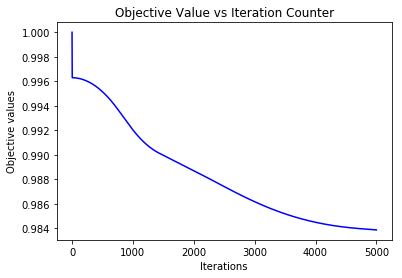

In [13]:
plt.plot(objs.reshape(-1, 1), color = "blue")
plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.title("Objective Value vs Iteration Counter")
plt.show()

**Compare the performance of kernel SVMs with different kernels (polynomial kernels with different orders, Gaussian RBF with different bandwidths, etc.).**

In [14]:
def computeGaussianKernel(x, y, bandwidth):
    return np.exp(-(1/(2*(bandwidth**2))) * np.linalg.norm(x - y)**2)

In [15]:
# Standardize step size for different kernels
eta = 1

K_poly_9 = computegram(X_digits_train, "polynomial", b=b, power=9)
K_poly_9_alphas, K_poly_9_objs = mysvm(K_poly_9, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

K_poly_1 = computegram(X_digits_train, "polynomial", b=b, power=1)
K_poly_1_alphas, K_poly_1_objs = mysvm(K_poly_1, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

K_poly_3 = computegram(X_digits_train, "polynomial", b=b, power=3)
K_poly_3_alphas, K_poly_3_objs = mysvm(K_poly_3, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

K_poly_5 = computegram(X_digits_train, "polynomial", b=b, power=5)
K_poly_5_alphas, K_poly_5_objs = mysvm(K_poly_5, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

K_RBF_1 = computegram(X_digits_train, "RBF", bandwidth=1)
K_RBF_1_alphas, K_RBF_1_objs = mysvm(K_RBF_1, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

K_RBF_3 = computegram(X_digits_train, "RBF", bandwidth=3)
K_RBF_3_alphas, K_RBF_3_objs = mysvm(K_RBF_3, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

K_RBF_5 = computegram(X_digits_train, "RBF", bandwidth=5)
K_RBF_5_alphas, K_RBF_5_objs = mysvm(K_RBF_5, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

K_RBF_7 = computegram(X_digits_train, "RBF", bandwidth=7)
K_RBF_7_alphas, K_RBF_7_objs = mysvm(K_RBF_7, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

K_RBF_9 = computegram(X_digits_train, "RBF", bandwidth=9)
K_RBF_9_alphas, K_RBF_9_objs = mysvm(K_RBF_9, y_digits_train, np.zeros((len(X_digits_train), 1)), h, lamb, eta, maxIter, epsilon)

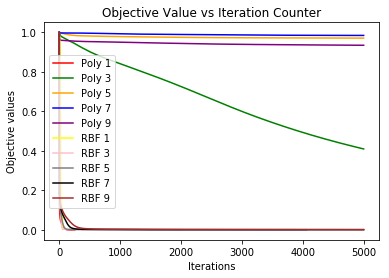

In [16]:
plt.plot(K_poly_1_objs.reshape(-1, 1), color = "red")
plt.plot(K_poly_3_objs.reshape(-1, 1), color = "green")
plt.plot(K_poly_5_objs.reshape(-1, 1), color = "orange")
plt.plot(objs.reshape(-1, 1), color = "blue")
plt.plot(K_poly_9_objs.reshape(-1, 1), color = "purple")

plt.plot(K_RBF_1_objs.reshape(-1, 1), color = "yellow")
plt.plot(K_RBF_3_objs.reshape(-1, 1), color = "pink")
plt.plot(K_RBF_5_objs.reshape(-1, 1), color = "gray")
plt.plot(K_RBF_7_objs.reshape(-1, 1), color = "black")
plt.plot(K_RBF_9_objs.reshape(-1, 1), color = "brown")

plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.title("Objective Value vs Iteration Counter")
plt.legend(["Poly 1", "Poly 3", "Poly 5", "Poly 7", "Poly 9", "RBF 1", "RBF 3", "RBF 5", "RBF 7", "RBF 9"])
plt.show()

In [17]:
def misclassification_error(alpha, X_train, X_test, y_test, type, bandwidth = 1, power = 1):
    """
    
    """
    y_pred = []
    for i in range(0, len(X_test)):
        if(type == "polynomial"):
            kernel = kerneleval(X_train, X_test[i], "polynomial", power=power)
        else:
            kernel = kerneleval(X_train, X_test[i], "RBF", bandwidth=bandwidth)
        if(kernel.T.dot(alpha) > 0):
            prediction = 1
        else:
            prediction = -1
        y_pred.append(prediction)
    return np.mean(np.array(y_pred).reshape(-1, 1) != y_test)

In [52]:
K_poly_1_misclass = misclassification_error(K_poly_1_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "polynomial", power=1)
K_poly_3_misclass = misclassification_error(K_poly_3_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "polynomial", power=3)
K_poly_5_misclass = misclassification_error(K_poly_5_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "polynomial", power=5)
K_poly_7_misclass = misclassification_error(alphas[-1], X_digits_train, X_digits_test, y_digits_test, "polynomial", power=7)
K_poly_9_misclass = misclassification_error(K_poly_9_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "polynomial", power=9)
K_RBF_1_misclass = misclassification_error(K_RBF_1_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "RBF", bandwidth=1)
K_RBF_3_misclass = misclassification_error(K_RBF_3_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "RBF", bandwidth=3)
K_RBF_5_misclass = misclassification_error(K_RBF_5_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "RBF", bandwidth=5)
K_RBF_7_misclass = misclassification_error(K_RBF_7_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "RBF", bandwidth=7)
K_RBF_9_misclass = misclassification_error(K_RBF_9_alphas[-1], X_digits_train, X_digits_test, y_digits_test, "RBF", bandwidth=9)

In [53]:
#display misclassification rates
df = pd.DataFrame({"Power/Bandwidth 1": (K_poly_1_misclass, K_RBF_1_misclass), "Power/Bandwidth 3": (K_poly_3_misclass, K_RBF_3_misclass),
                "Power/Bandwidth 5": (K_poly_5_misclass, K_RBF_5_misclass), "Power/Bandwidth 7": (K_poly_7_misclass, K_RBF_7_misclass),
                "Power/Bandwidth 9": (K_poly_9_misclass, K_RBF_9_misclass)})
df.rename(index={0:"Polnomial Kenel", 1:"RBF"}, inplace = True)
display(df)

,Power/Bandwidth 1,Power/Bandwidth 3,Power/Bandwidth 5,Power/Bandwidth 7,Power/Bandwidth 9
Polnomial Kenel,0.022222,0.022222,0.022222,0.133333,0.022222
RBF,0.011111,0.011111,0.011111,0.011111,0.000000


TALK ABOUT THIS!

### Exercise 3: Data Competition Project

**In this exercise, you are going to train support vector machines (SVMs) using the data competition 2 project dataset (with 100 classes). You will consider here all classes in the dataset. You may work on this exercise on your own computer first. Note, however, that you need AWS to run the experiments for this entire exercise.**

In [20]:
data_dir = "../Kaggle/data558spring2019-competition2"

X_train = np.load(os.path.join(data_dir, 'train_features.npy'))
y_train = np.load(os.path.join(data_dir, 'train_labels.npy')).reshape(-1, 1)
X_test = np.load(os.path.join(data_dir, 'val_features.npy'))
y_test = np.load(os.path.join(data_dir, 'val_labels.npy')).reshape(-1, 1)

kaggle = np.load(os.path.join(data_dir, 'test_features.npy'))

# standardize X data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
kaggle = scaler.transform(kaggle)

print("Dimension of X_train:", X_train.shape)
print("Dimension of y_train:", y_train.shape)
print("Dimension of X_test:", X_test.shape)
print("Dimension of y_test:", y_test.shape)

Dimension of X_train: (50000, 4096)
Dimension of y_train: (50000, 1)
Dimension of X_test: (10000, 4096)
Dimension of y_test: (10000, 1)


**In a one-vs-one fashion, for each pair of classes, train a linear SVM classifier using scikitlearn’s function `LinearSVC`, with the default value for the regularization parameter. Compute the *multi-class misclassification error* obtained using these classifiers trained
in a one-vs-one fashion**

In [21]:
def getData(label1, label2):
    """
    Gets training and test data from kaggle dataset filtered by 2 specified labels
    Inputs:
        - label1: first label for filtering kaggle image dataset (0 - 99)
        - label2: second label for filtering kaggle image dataset (0 - 99), must be different than label1
    Outputs:
        - X_train: filtered x values to use for model training
        - y_train: filtered y values to use for model training
    """
    #filters x training values down to rows with matching input labels
    x_train_filtered = np.zeros((1000, X_train.shape[1]))
    y_train_filtered = np.zeros((1000, 1))
    index = 0
    for i in range(y_train.shape[0]):
        if(y_train[i] == label1 or y_train[i] == label2):
            x_train_filtered[index, :] = X_train[i].T
            y_train_filtered[index, :] = y_train[i]
            index += 1
    
    # reset train y data to -1 and 1 to fit machine learning standards
    y_train_filtered[y_train_filtered == label1] = -1
    y_train_filtered[y_train_filtered == label2] = 1

    # standardize x values
    xScaler = preprocessing.StandardScaler()
    X_train_filtered = xScaler.fit_transform(x_train_filtered)
    
    return X_train_filtered, y_train_filtered

In [42]:
def oneVsOneSVM(X, y, test):
    predictions = []
    for i in range(0,100):
        for j in range(i + 1, 100):
            X_train_OneVsOne, y_train_OneVsOne = getData(i, j)
            clf = LinearSVC(random_state=0, tol=.001, max_iter=100, fit_intercept=False).fit(X_train_OneVsOne, y_train_OneVsOne)
            prediction = clf.predict(test)
            predictionVect = []
            for pred in prediction:
                if(pred == -1):
                    predictionVect.append(i)
                else:
                    predictionVect.append(j)
            predictions.append(predictionVect)
    return predictions

In [ ]:
def averagePredictions(predictions):
    finalPredictions = []
    for i in range(0, len(X_test)):
        preds = []
        for prediction in predictions:
            if(prediction[i] != -1):
                preds.append(prediction[i])
        if(len(preds) > 0):
            finalPredictionsVal.append(Counter(preds).most_common(1)[0][0])
        else:
            finalPredictionsVal.append(0)
    return finalPredictions

In [ ]:
def calcMultiClassMisclassification(predictions, labels):
    misclassification = 0
    for i in range(0, len(labels)):
    if(labels[i] != predictions[i]):
        misclassification += 1
    return misclassification / len(labels)

In [ ]:
predictionsValOneVsOne = oneVsOneSVM(X_train, y_train, X_test)
yValOneVOnePredictions = averagePredictions(predictionsValOneVsOne)
yValOneVOneMisclassification = calcMultiClassMisclassification(yValOneVOnePredictions, y_test)
print("Multi-class misclassification rate for validation data set with one vs one Linear SVM ", yValOneVOneMisclassification)

In [ ]:
predictionsKaggleOneVsOne = oneVsOneSVM(X_train, y_train, kaggle)
kaggleOneVOnePredictions = averagePredictions(predictionsKaggleOneVsOne)

# make csv file for Kaggle submission
kaggleOneVOnePredictionsDF = pd.DataFrame({"Category": kaggleOneVOnePredictions})
kaggleOneVOnePredictionsDF.to_csv("kaggleHW7ScikitOneVsOneSVM.csv", sep=',')

**In a one-vs-rest fashion, for each class, train a linear SVM classifier using scikit-learn’s function `LinearSVC`, with the default value for $\lambda_c$. Compute the multi-class misclassification error obtained using these classifiers trained in a one-vs-rest fashion.**

In [41]:
def oneVsRestSVM(X, y, test):
    predictions = []
    for label in np.unique(y):
        print(label)
        y_temp = copy.deepcopy(y)
        y_temp[y_temp == label] = -1
        y_temp[y_temp != -1] = 1
        clf = LinearSVC(random_state=0, tol=1, max_iter=50, fit_intercept=False).fit(X, y_temp)
        prediction = clf.predict(test)
        predictionVect = []
        for pred in prediction:
            if(pred == -1):
                predictionVect.append(label)
            else:
                predictionVect.append(-1)
        predictions.append(predictionVect)
    return predictions  

In [ ]:
predictionsValOneVRest = oneVsRestSVM(X_train, y_train, X_test)
yValOneVRestPredictions = averagePredictions(predictionsValOneVRest)
yValOneVRestMisclassification = calcMultiClassMisclassification(yValOneVRestPredictions, y_test)
print("Multi-class misclassification rate for validation data set with one vs rest Linear SVM ", yValOneVRestMisclassification)

In [ ]:
predictionsKaggleOneVsRest = oneVsRestSVM(X_train, y_train, kaggle)
kaggleOneVRestPredictions = averagePredictions(predictionsKaggleOneVsRest)

# make csv file for Kaggle submission
kaggleOneVRestPredictionsDF = pd.DataFrame({"Category": kaggleOneVRestPredictions})
kaggleOneVRestPredictionsDF.to_csv("kaggleHW7ScikitOneVsRestSVM.csv", sep=',')

**Redo all questions above now using your own code for the linear SVMs from Exercise 1. Make to sure to run preliminary experiments to decide how to set the stopping criterion to a value that allows the experiments to complete in a reasonable amount of time.**

In [54]:
def oneVsOneMySVM(X, y, test):
    predictions = []
    for i in range(0,100):
        for j in range(i + 1, 100):
            print(i, j)
            X_train_OneVsOne, y_train_OneVsOne = getData(i, j)
            K = computegram(X_train_OneVsOne, "polynomial", b=b, power=1)
            alphas, objs = mysvm(K, y_train_OneVsOne, np.zeros((len(X_train_OneVsOne), 1)), 0.5, 1, 1, 1000, 0.0001)
            label_predictions = []
            for i in range(0, len(test)):
                kernel = kerneleval(X_train_OneVsOne, test[i], "polynomial", power=1)
                if(kernel.T.dot(alphas[-1]) > 0):
                    prediction = -1
                else:
                    prediction = 1
                label_predictions.append(prediction)
            predictions.append(label_predictions)
    return predictions

In [ ]:
predictionsValOneVsOneMySVM = oneVsOneMySVM(X_train, y_train, X_test)
yValOneVOnePredictionsMySVM = averagePredictions(predictionsValOneVsOne)
yValOneVOneMisclassificationMySVM = calcMultiClassMisclassification(yValOneVOnePredictionsMySVM, y_test)
print("Multi-class misclassification rate for validation data set with one vs one Linear SVM ", yValOneVOneMisclassificationMySVM)

0 1


In [ ]:
predictionsKaggleOneVsOneMySVM = oneVsOneMySVM(X_train, y_train, kaggle)
kaggleOneVOnePredictionsMySVM = averagePredictions(predictionsKaggleOneVsOneMySVM)

# make csv file for Kaggle submission
kaggleOneVOnePredictionsDFMySVM = pd.DataFrame({"Category": kaggleOneVOnePredictionsMySVM})
kaggleOneVOnePredictionsDFMySVM.to_csv("kaggleHW7ScikitOneVsOneMySVM.csv", sep=',')

In [39]:
def oneVsRestMySVM(X, y, test):
    predictions = []
    
    K = computegram(X_train, "polynomial", b=b, power=1)
    
    for label in np.unique(y):
        print(label)
        y_temp = copy.deepcopy(y)
        y_temp[y_temp == label] = -1
        y_temp[y_temp != -1] = 1
        alphas, objs = mysvm(K, y_temp, np.zeros((len(K), 1)), 0.5, 1, 1, 1000, 0.0001)
        label_predictions = []
        for i in range(0, len(test)):
            kernel = kerneleval(X, test[i], "polynomial", power=1)
            if(kernel.T.dot(alphas) > 0):
                prediction = -1
            else:
                prediction = 1
            label_predictions.append(prediction)
        predictions.append(label_predictions)
    return predictions

MemoryError: 

In [ ]:
K_poly_predictions = oneVsRestMySVM(X_train, y_train, X_test)